# Anti-inflammatory peptide discovery

This notebook analyzes the peptides that we predicted have anti-inflammatory bioactivity using an AutoPeptideML binary classifier.
It joins these predictions to other metadata to see if there is any additional signals that we can leverage to know that the anti-inflammatory predictions are accurate.

## Notebook set up

In [1]:
library(tidyverse)

── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
setwd("..")

## Read in data

In [3]:
# read in BLASTp results for peptigate predictions vs. 5 known antipruritic peptides
antiinflammatory <- read_tsv("outputs/analysis/predict_antiinflammatory/autopeptideml_antiinflammatory_predictions.tsv",
                             show_col_types = FALSE)

# filter to peptides that had a score of 1
antiinflammatory1 <- antiinflammatory  %>%
 filter(antiinflammatory == 1)

In [4]:
head(antiinflammatory1)

peptide_id,sequence,antiinflammatory
<chr>,<chr>,<dbl>
Transcript_991526.p2_start20_end37,RPRGHPQFDDSSNALEAR,1
Transcript_576526,TAEIIPEPSTFASLKFYTQFHYVKLRVYAIEPGYTTLDGNHATVRYKHNSVHIIWQ,1
Transcript_992324.p3_start107_end123,GGPPADIAGPHRVFHSK,1
Transcript_991525.p3_start73_end82,SDKVHTAVPK,1
Transcript_993171.p2_start124_end151,SEVIEGEVTEIEIDRFSNRQIDPSSFSS,1
Transcript_992481.p4_start84_end105,SALLEGESDKEHSNESSSDDAE,1


In [5]:
nrow(antiinflammatory1)
length(unique(antiinflammatory1$sequence))

[1] 9859

[1] 8735

In [6]:
# read in BLASTp results for peptigate vs. known human peptides
matching_human <- read_tsv("outputs/analysis/compare_human/humanpeptideatlas_blastp_matches.tsv", show_col_types = FALSE) %>%
  group_by(qseqid) %>%
  slice_max(bitscore) %>%
  slice_min(evalue) %>%
  slice_head(n = 1) %>%
  ungroup() %>%
  rename_with(~paste0("humanpeptideatlas_blast_", .x))

In [7]:
# read in peptigate results
peptigate <- Sys.glob("outputs/tsa_tick_sg_transcriptomes/*/predictions/peptide_predictions.tsv") %>%
  map_dfr(read_tsv, show_col_types = FALSE)  %>%
  rename_with(~paste0("peptigate_", .x))

In [8]:
# read in peptigate results
peptigate_annotations <- Sys.glob("outputs/tsa_tick_sg_transcriptomes/*/predictions/peptide_annotations.tsv") %>%
  map_dfr(read_tsv, show_col_types = FALSE)  %>%
  rename_with(~paste0("peptigate_", .x))

In [9]:
# read in cleavage peptide parent protein annotations by eggnog
eggnog <- read_tsv("outputs/analysis/annotate_cleavage_parent_proteins/eggnog.emapper.annotations",
                   comment = "##", show_col_types = FALSE) %>%
  rename(query = `#query`) %>%
  group_by(query) %>%
  slice_min(evalue) %>%
  slice_max(score) %>%
  slice_head(n = 1) %>%
  ungroup() %>%
  rename_with(~paste0("parent_protein_eggnog_", .x))

In [10]:
# read in cleavage peptide parent protein annotations by kegg
kegg <- read_tsv("outputs/analysis/annotate_cleavage_parent_proteins/kofamscan.tsv", show_col_types = FALSE,
                 skip =2, col_names = c("tmp", "gene_name", "KO", "threshold", "score", "evalue", "KO_definition")) %>%
  filter(score >= threshold) %>%
  select(-tmp) %>%
  # select best match 
  group_by(gene_name) %>%
  slice_max(score) %>%
  ungroup() %>%
  rename_with(~paste0("parent_protein_kegg_", .x))

In [11]:
# read in clustering information
clustering <- read_tsv("outputs/analysis/clustering/all_peptides_0.8_cluster.tsv",
                       show_col_types = FALSE,
                       col_names = c("mmseqs2_representative_sequence",
                                     "mmseqs2_cluster_member")) %>%
  mutate(mmseqs2_source_representative_txome = ifelse(grepl(pattern = "Transcript_", x = mmseqs2_representative_sequence), 
                                                      "amblyommaamericanum",
                                                      str_extract(mmseqs2_representative_sequence, "G.*?01")),
         mmseqs2_source_cluster_member_txome = ifelse(grepl(pattern = "Transcript_", x = mmseqs2_cluster_member), 
                                                      "amblyommaamericanum",
                                                      str_extract(mmseqs2_cluster_member, "G.*?01")))

In [12]:
# summarize the cluster sizes and whether the clusters have members from multiple transcriptomes
cluster_summary <- clustering %>%
  group_by(mmseqs2_representative_sequence) %>%
  mutate(mmseqs2_cluster_size = n(),
         mmseqs2_cluster_same_txome_count = sum(mmseqs2_source_representative_txome == mmseqs2_source_cluster_member_txome),
         mmseqs2_cluster_same_txome_fraction = mmseqs2_cluster_same_txome_count / mmseqs2_cluster_size) %>%
  ungroup() %>%
  select(mmseqs2_representative_sequence, mmseqs2_cluster_size, mmseqs2_cluster_same_txome_count, mmseqs2_cluster_same_txome_fraction) %>%
  distinct()

In [13]:
# read in transcriptome: species metadata
aa <- data.frame(tsa_accession = "amblyommaamericanum",
                 species = "Amblyomma americanum",
                 bioproject = "PRJNA834823")
metadata <- read_csv("inputs/tick_sg_transcriptomes_tsa.csv", show_col_types = FALSE)
metadata <- bind_rows(metadata, aa) %>%
  select(tsa_accession, species)

New names:
• `` -> `...12`


## Combine together 

In [14]:
antiinflammatory1 <- antiinflammatory1 %>%
  # join with metadata so we know which species each query peptide came from
  mutate(tsa_accession = ifelse(grepl(x = peptide_id, pattern = "^G"), 
                                gsub("(G.*?01).*", "\\1", peptide_id),
                                "amblyommaamericanum")) %>%
  left_join(metadata, by = c("tsa_accession"), relationship = "many-to-one") %>%
  # join to the peptigate results table to see which tool made the prediction
  left_join(peptigate, by = c("peptide_id" = "peptigate_peptide_id")) %>%
  # if the prot seq is duplicated (one is I. ricinus, one in A. americanum),
  # just pick the first sequence
  group_by(sequence) %>%
  slice_head(n = 1) %>%
  ungroup() %>%
  # join to peptigate annotation data
  left_join(peptigate_annotations, by = c("peptide_id" = "peptigate_peptide_id")) %>%
  # join to human data so we know whether any of these may be human mimics
  left_join(matching_human, by = c("peptide_id" = "humanpeptideatlas_blast_qseqid")) %>%
  # join to eggnog parent protein annotations
  mutate(parent_protein_id = gsub("_start.*", "", peptide_id)) %>%
  left_join(eggnog, by = c("parent_protein_id" = "parent_protein_eggnog_query")) %>%
  left_join(kegg, by = c("parent_protein_id" = "parent_protein_kegg_gene_name")) %>%
  # join to clustering info to see if any of the peptides are similar to each other
  left_join(clustering, by = c("peptide_id" = "mmseqs2_cluster_member")) %>%
  # join to clustering summary to get cluster sizes for peptides
  left_join(cluster_summary, by = "mmseqs2_representative_sequence")

In [15]:
head(antiinflammatory1)

peptide_id,sequence,antiinflammatory,tsa_accession,species,peptigate_start,peptigate_end,peptigate_peptide_type,peptigate_peptide_class,peptigate_prediction_tool,⋯,parent_protein_kegg_threshold,parent_protein_kegg_score,parent_protein_kegg_evalue,parent_protein_kegg_KO_definition,mmseqs2_representative_sequence,mmseqs2_source_representative_txome,mmseqs2_source_cluster_member_txome,mmseqs2_cluster_size,mmseqs2_cluster_same_txome_count,mmseqs2_cluster_same_txome_fraction
<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>
GBBM01005295.1.p1_start321_end335,AAAGTNTLILITSLA,1,GBBM01,Amblyomma triste,321,335,cleavage,Propeptide,deeppeptide,⋯,NA,NA,NA,NA,GBBM01005295.1.p1_start321_end335,GBBM01,GBBM01,1,1,1.0
GBBM01005295.1.p1_start321_end335,AAAGTNTLILITSLA,1,GBBM01,Amblyomma triste,321,335,cleavage,Propeptide,deeppeptide,⋯,NA,NA,NA,NA,GBBM01005295.1.p1_start321_end335,GBBM01,GBBM01,1,1,1.0
Transcript_997393.p1_start74_end84,AAAPSPQDEKD,1,amblyommaamericanum,Amblyomma americanum,74,84,cleavage,Propeptide,deeppeptide,⋯,NA,NA,NA,NA,Transcript_997393.p1_start74_end84,amblyommaamericanum,amblyommaamericanum,1,1,1.0
Transcript_851.p1_start51_end74,AACSSATGGHITARNLVMISPLLT,1,amblyommaamericanum,Amblyomma americanum,51,74,cleavage,Propeptide,deeppeptide,⋯,NA,NA,NA,NA,Transcript_851.p1_start51_end74,amblyommaamericanum,amblyommaamericanum,1,1,1.0
GADI01001786.1.p1_start24_end38,AADENSLPEFVKNKR,1,GADI01,Ixodes ricinus,24,38,cleavage,Propeptide,deeppeptide,⋯,NA,NA,NA,NA,GADI01001786.1.p1_start24_end38,GADI01,GADI01,1,1,1.0
GEGO01000613.1.p1_start26_end44,AAEDDDTNKNELPKEVENV,1,GEGO01,Ixodes ricinus,26,44,cleavage,Propeptide,deeppeptide,⋯,NA,NA,NA,NA,GEGO01000613.1.p1_start26_end44,GEGO01,GEGO01,5,2,0.4


## Analyze the results

In [16]:
# how many total sequences were annotated as anti-inflammatory bioactivity?
nrow(antiinflammatory1)
length(unique(antiinflammatory1$sequence))

[1] 8792

[1] 8735

In [17]:
# what was the species x peptide hit makeup?
antiinflammatory1 %>%
  group_by(species) %>%
  tally() 

species,n
<chr>,<int>
Amblyomma americanum,6143
Amblyomma cajennense,38
Amblyomma maculatum,82
Amblyomma parvum,7
Amblyomma triste,48
Amblyomma tuberculatum,12
Hyalomma dromedarii,347
Hyalomma excavatum,29
Ixodes ricinus,302


In [18]:
# how many peptides also had hits to the human peptide atlas?
antiinflammatory1 %>%
  mutate(humanpeptideatlas_blast_result = ifelse(!is.na(humanpeptideatlas_blast_bitscore), "blast hit", "no blast hit")) %>%
  select(sequence, humanpeptideatlas_blast_result) %>%
  distinct() %>%
  group_by(humanpeptideatlas_blast_result) %>%
  tally()

humanpeptideatlas_blast_result,n
<chr>,<int>
blast hit,54
no blast hit,8681


In [19]:
# how many peptides had hits to the peptipedia database?
antiinflammatory1 %>%
  mutate(peptigate_peptipedia_blast_result = ifelse(!is.na(peptigate_peptipedia_blast_bitscore), "blast hit", "no blast hit")) %>%
  select(sequence, peptigate_peptipedia_blast_result) %>%
  distinct() %>%
  group_by(peptigate_peptipedia_blast_result) %>%
  tally()

peptigate_peptipedia_blast_result,n
<chr>,<int>
blast hit,62
no blast hit,8673


In [20]:
# how similar are these sequences at an 80% percent identity?
nrow(antiinflammatory1)
length(unique(antiinflammatory1$sequence))
length(unique(antiinflammatory1$mmseqs2_representative_sequence))

[1] 8792

[1] 8735

[1] 8535

In [21]:
# how many sequences were cleavage vs. sORF
antiinflammatory1 %>%
 select(sequence, peptigate_peptide_type, peptigate_prediction_tool) %>%
 distinct() %>%
 group_by(peptigate_peptide_type, peptigate_prediction_tool) %>%
 tally()

peptigate_peptide_type,peptigate_prediction_tool,n
<chr>,<chr>,<int>
cleavage,deeppeptide,2119
cleavage,nlpprecursor,149
sORF,plmutils,6467


In [23]:
2119+149

[1] 2268

## See if other bioactivity predictions give pointers as to the veracity of the anti-inflammatory prediction

I don't see any clear signals that I would be comfortable acting on right now in the results of other bioactivity binary classifiers.

In [25]:
antiinflammatory1_other_bioactivity <- antiinflammatory1 %>%
 rowwise() %>%
 mutate(bioactivity_sum = sum(c_across(c(peptigate_AB, peptigate_ACE, peptigate_ACP,
                                         peptigate_AF, peptigate_AMAP, peptigate_AMP,
                                         peptigate_AOX, peptigate_APP, peptigate_AV, 
                                         peptigate_BBP, peptigate_DPPIV, peptigate_MRSA, 
                                         peptigate_Neuro, peptigate_QS, peptigate_TOX, 
                                         peptigate_TTCA)),
                               na.rm = TRUE))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


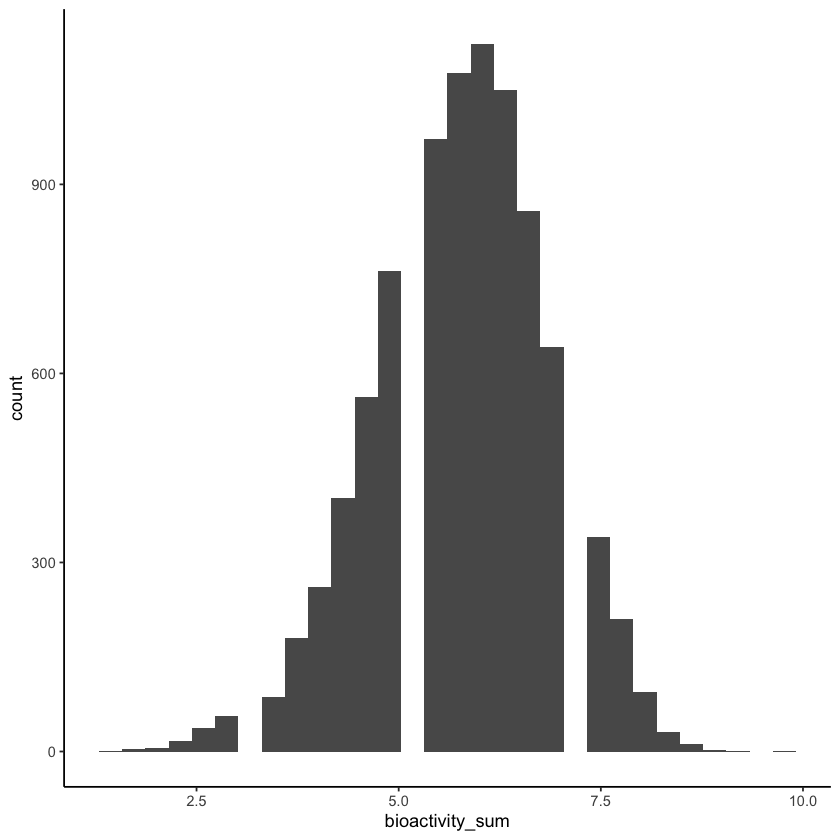

In [26]:
ggplot(antiinflammatory1_other_bioactivity, aes(x = bioactivity_sum)) +
  geom_histogram() +
  theme_classic()

## Filtering to a smaller set of anti-inflammatory peptides to screen for bioactivity

Remove peptides that don't cluster at 80% with another peptide.
These peptides don't have orthogonal support in evolutionarily close neighbors (other ticks), which makes it more likely that they are not real.

Note that technically a peptide could be predicted from the same transcriptome twice but in practice we did not observe this happening very frequently.

In [35]:
antiinflammatory1_clustersize2 <- antiinflammatory1 %>%
  filter(mmseqs2_cluster_size > 1)

nrow(antiinflammatory1_clustersize2)
length(unique(antiinflammatory1_clustersize2$mmseqs2_representative_sequence))

[1] 830

[1] 630

In [34]:
antiinflammatory1_clustersize2 %>%
  group_by(species) %>%
  tally()

species,n
<chr>,<int>
Amblyomma americanum,309
Amblyomma cajennense,17
Amblyomma maculatum,19
Amblyomma parvum,4
Amblyomma triste,10
Amblyomma tuberculatum,1
Hyalomma dromedarii,88
Hyalomma excavatum,7
Ixodes ricinus,96


In [36]:
antiinflammatory1_clustersize2 %>%
  group_by(peptigate_prediction_tool) %>%
  tally()

peptigate_prediction_tool,n
<chr>,<int>
deeppeptide,745
nlpprecursor,14
plmutils,71


In [50]:
# loop through different cluster size cutoffs and report how many peptides are retained
num_clusters_at_different_cutoffs <- data.frame(cut_off = numeric(), 
                                                num_peptides = numeric(),
                                                num_clusters = numeric())
for(i in 1:46){
    tmp <- antiinflammatory1 %>%
      filter(mmseqs2_cluster_size > i)
    num_clusters_at_different_cutoffs[i, 1] <- i + 1
    num_clusters_at_different_cutoffs[i, 2] <- nrow(tmp)
    num_clusters_at_different_cutoffs[i, 3] <- length(unique(tmp$mmseqs2_representative_sequence))
}

In [51]:
num_clusters_at_different_cutoffs

,cut_off,num_peptides,num_clusters
,<dbl>,<dbl>,<dbl>
1,2,830,630
2,3,485,318
3,4,333,198
4,5,263,146
5,6,228,115
6,7,202,96
7,8,165,78
8,9,142,66
9,10,125,56


In [22]:
# write the results joined with other metadata to a file
write_tsv(antiinflammatory1, "outputs/analysis/20240404_filtered_antiinflammatory_with_metadata.tsv")

In [53]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/taylorreiter/miniconda3/envs/tidyjupyter/lib/libopenblasp-r0.3.26.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/New_York
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] lubridate_1.9.3 forcats_1.0.0   stringr_1.5.1   dplyr_1.1.4    
 [5] purrr_1.0.2     readr_2.1.5     tidyr_1.3.1     tibble_3.2.1   
 [9] ggplot2_3.5.0   tidyverse_2.0.0

loaded via a namespace (and not attached):
 [1] bit_4.0.5        gtable_0.3.4     jsonlite_1.8.8   compiler_4.3.3  
 [5] crayon_1.5.2     tidyselect_1.2.0 IRdisplay_1.1    parallel_4.3.3  
 [9] scales_1.3.0     uuid_1.2-0       fastmap_1.1.1    IRkernel_1.3.2  
[13] R6_2.5.1         labeling_0.4.3   generics_0.1.3 